In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib as mpl
import seaborn as sns

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import datasets, inout, export

pd.set_option('display.max_columns', None)

#xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

#keep track of 1000 bootstraps
from tqdm.notebook import tqdm

#time counter
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

# #display all outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

#pretty
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
mpl.rcParams['font.sans-serif'] = 'Arial'
pd.set_option('display.max_columns', None)

from tqdm.notebook import tqdm

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


time: 51.6 ms (started: 2022-12-09 14:38:19 -06:00)


In [2]:
user = 'CAG'     # defines top hierarchy of output folder
outfolder = '32_xgboost_handicap'    # name of notebook

def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

time: 686 µs (started: 2022-12-09 14:38:19 -06:00)


In [3]:
no_vap_flags = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 
]

only_had_vap_flag = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 'had_nonviral_vap',
]

both_vap_flags = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 'had_nonviral_vap', 'vap_indeterminate_notcured'
]

time: 4.59 ms (started: 2022-12-09 14:38:27 -06:00)


# First two

In [70]:
worsttwo = pd.read_csv(
    inout.get_material_path('general/31_worst_two/data_worsttwo_adjudicated_220919_1405.csv.gz'), 
    index_col=0)

time: 82.5 ms (started: 2022-12-09 15:27:59 -06:00)


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


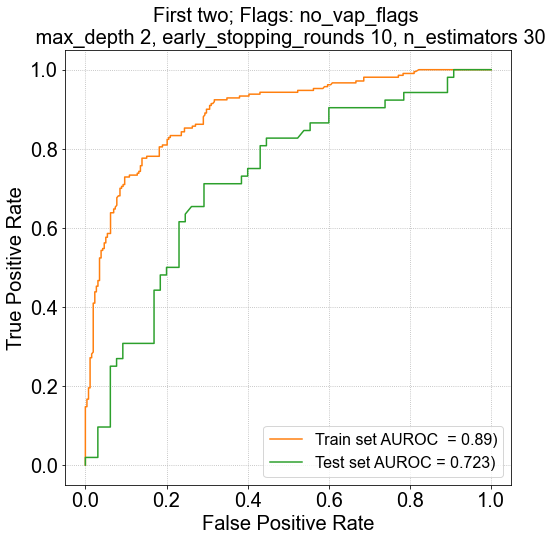

time: 335 ms (started: 2022-12-09 15:27:59 -06:00)


In [71]:
max_depth = 2
early_stopping_rounds=10
n_estimators = 30
flags = no_vap_flags
flag_name = 'no_vap_flags'

#flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'First two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

fig.savefig(f"xgboost_first_{flag_name}.pdf")

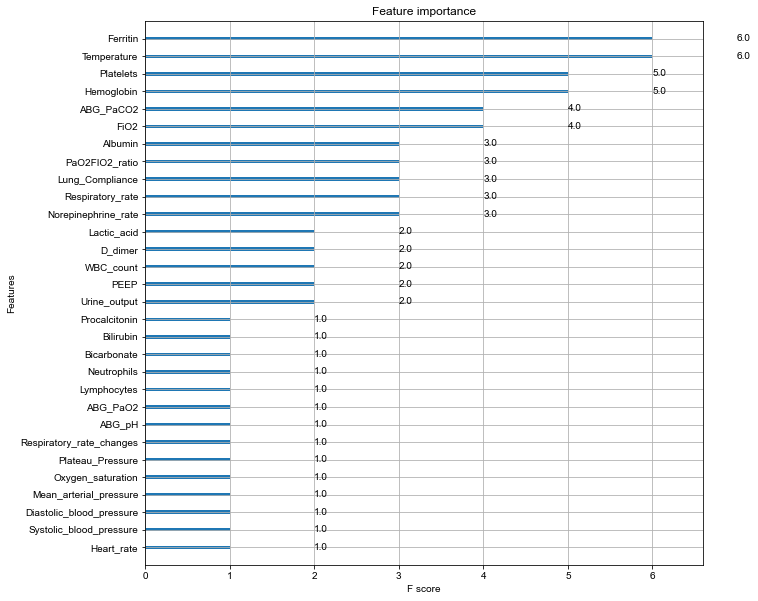

time: 415 ms (started: 2022-12-09 15:28:14 -06:00)


In [74]:

plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)

plt.savefig(f"xgboost_first_{flag_name}_importance.pdf")

  0%|          | 0/1000 [00:00<?, ?it/s]

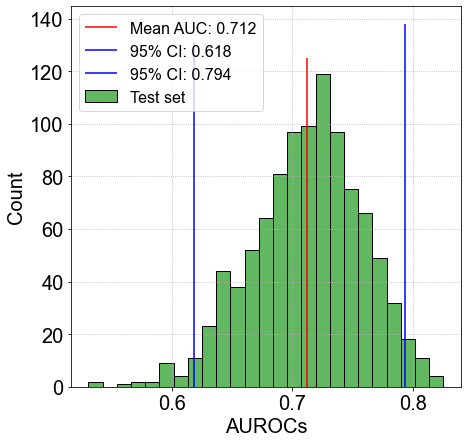

time: 33.8 s (started: 2022-12-09 15:15:06 -06:00)


In [52]:
n_boot = 1000
auc_train = []
auc_test = []


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_first_{flag_name}_bootstrap.pdf")


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


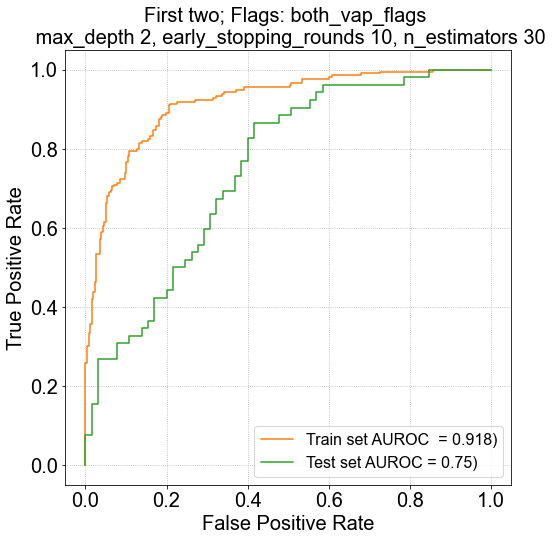

time: 383 ms (started: 2022-12-09 15:28:25 -06:00)


In [75]:
max_depth = 2
early_stopping_rounds=10
n_estimators = 30
flags = both_vap_flags
flag_name = 'both_vap_flags'

#flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'First two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()


fig.savefig(f"xgboost_first_{flag_name}.pdf")

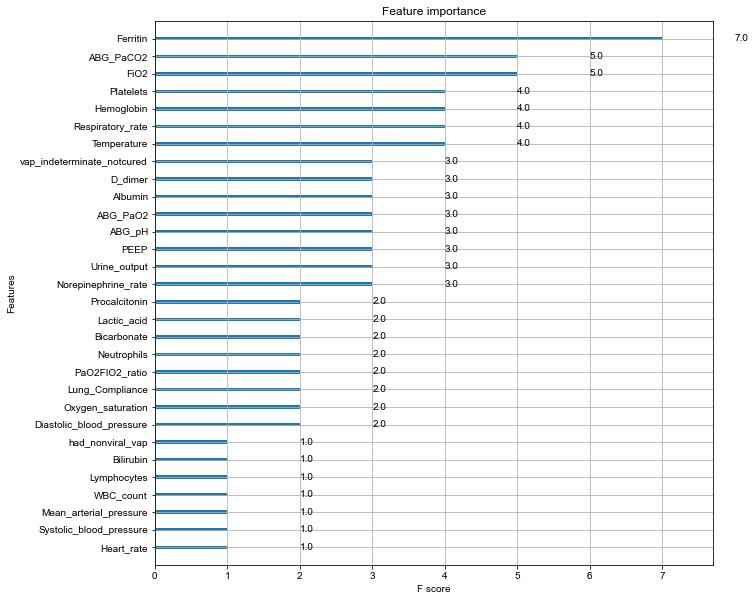

time: 399 ms (started: 2022-12-09 15:28:30 -06:00)


In [76]:

plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)

plt.savefig(f"xgboost_first_{flag_name}_importance.pdf")

  0%|          | 0/1000 [00:00<?, ?it/s]

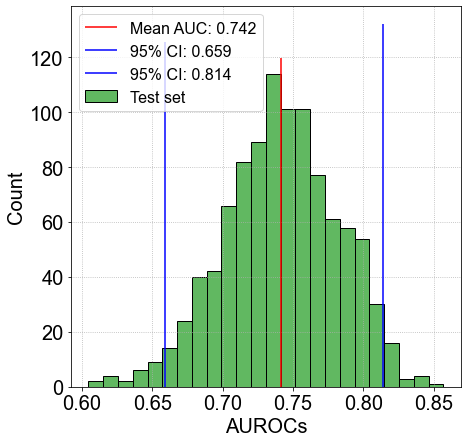

time: 35.6 s (started: 2022-12-09 15:15:41 -06:00)


In [55]:
n_boot = 1000
auc_train = []
auc_test = []


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_first_{flag_name}_bootstrap.pdf")


# Median two days 

In [77]:
worsttwo = pd.read_csv(
    inout.get_material_path('CAG/31_worst_two/middletwo_adjudicated_221206_0735.csv.gz'), 
    index_col=0)

time: 37.3 ms (started: 2022-12-09 15:28:38 -06:00)


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


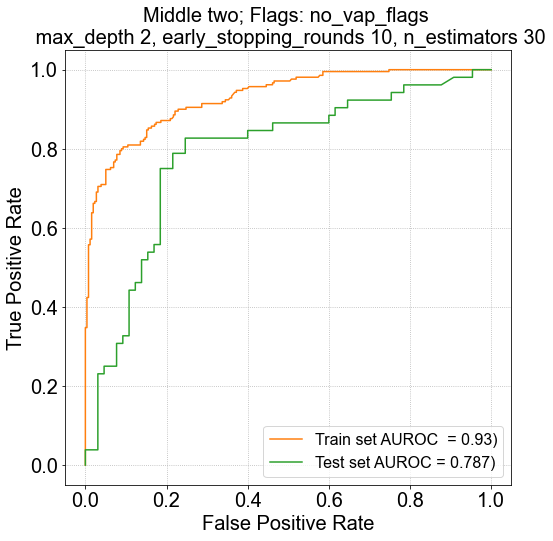

time: 280 ms (started: 2022-12-09 15:28:38 -06:00)


In [78]:
max_depth = 2
early_stopping_rounds=10
n_estimators = 30
flags = no_vap_flags
flag_name = 'no_vap_flags'

#flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'Middle two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

fig.savefig(f"xgboost_middle_{flag_name}.pdf")



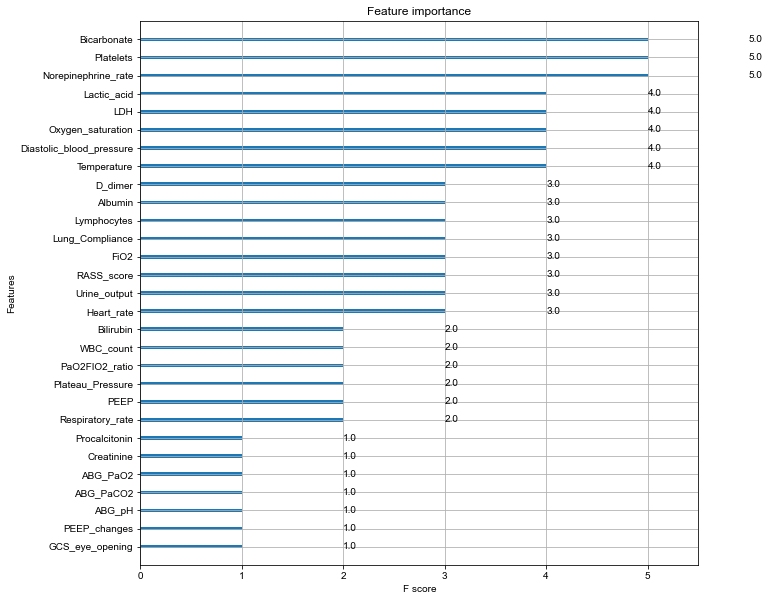

time: 478 ms (started: 2022-12-09 15:28:42 -06:00)


In [79]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)
plt.savefig(f"xgboost_middle_{flag_name}_importance.pdf")


  0%|          | 0/1000 [00:00<?, ?it/s]

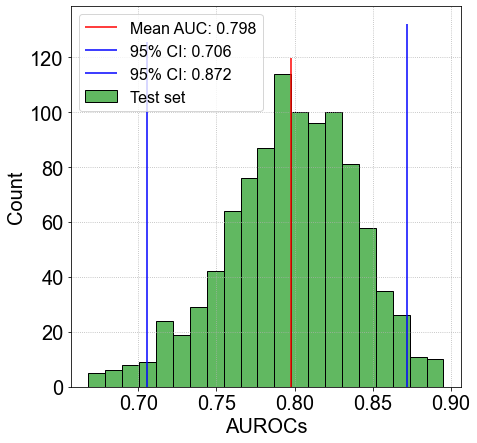

time: 33.1 s (started: 2022-12-09 15:16:17 -06:00)


In [59]:
n_boot = 1000
auc_train = []
auc_test = []


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_middle_{flag_name}_bootstrap.pdf")


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


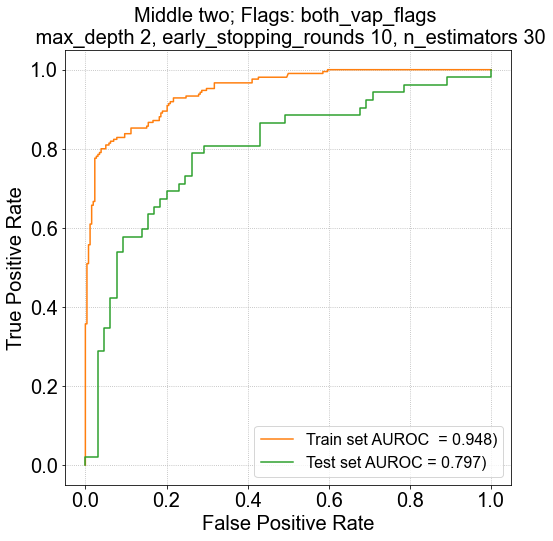

time: 264 ms (started: 2022-12-09 15:28:45 -06:00)


In [80]:
max_depth = 2
early_stopping_rounds=10
n_estimators = 30
flags = both_vap_flags
flag_name = 'both_vap_flags'

#flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'Middle two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

fig.savefig(f"xgboost_middle_{flag_name}.pdf")


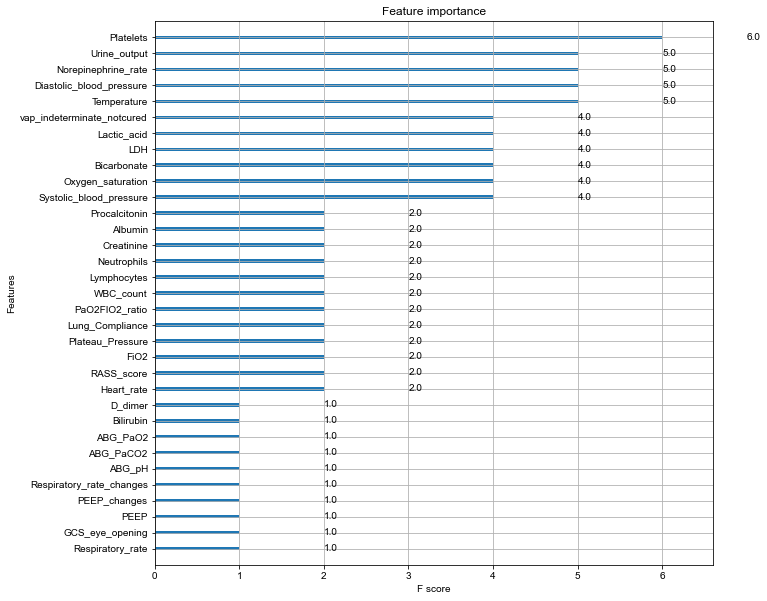

time: 462 ms (started: 2022-12-09 15:28:51 -06:00)


In [81]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)

plt.savefig(f"xgboost_middle_{flag_name}_importance.pdf")


  0%|          | 0/1000 [00:00<?, ?it/s]

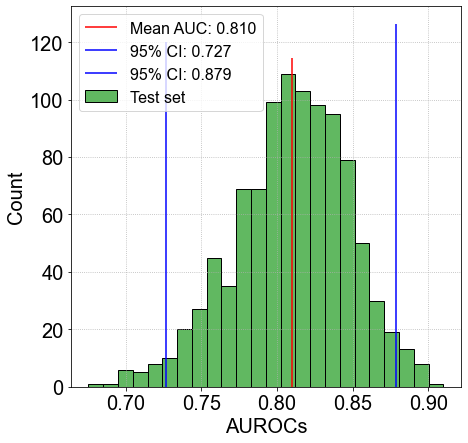

time: 36.2 s (started: 2022-12-09 15:16:51 -06:00)


In [62]:
n_boot = 1000
auc_train = []
auc_test = []
max_depth = 2
early_stopping_rounds=10
n_estimators = 30
flags = both_vap_flags
flag_name = 'both_vap_flags'


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_middle_{flag_name}_bootstrap.pdf")


# last two days worst values

In [82]:
worsttwo = pd.read_csv(
    inout.get_material_path('CAG/31_worst_two/data_last_worsttwo_adjudicated_221129_0904.csv.gz'), 
    index_col=0)

time: 32.7 ms (started: 2022-12-09 15:28:55 -06:00)


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


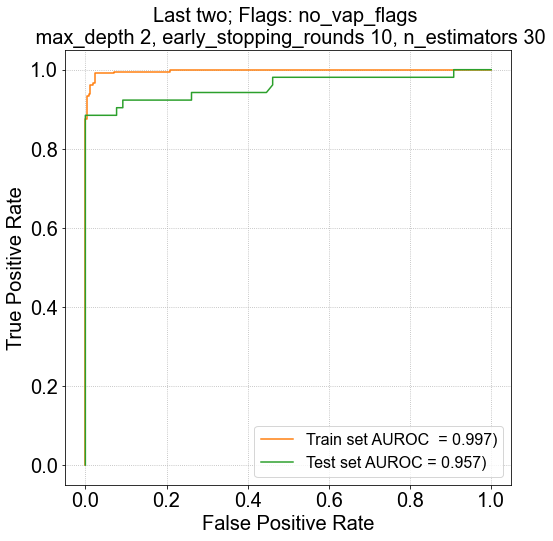

time: 253 ms (started: 2022-12-09 15:28:56 -06:00)


In [83]:
#decrease max_depth and early_stopping_rounds

max_depth = 2
early_stopping_rounds=10
n_estimators = 30

flags = no_vap_flags
flag_name = 'no_vap_flags'

#both flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'Last two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

fig.savefig(f"xgboost_last_{flag_name}.pdf")

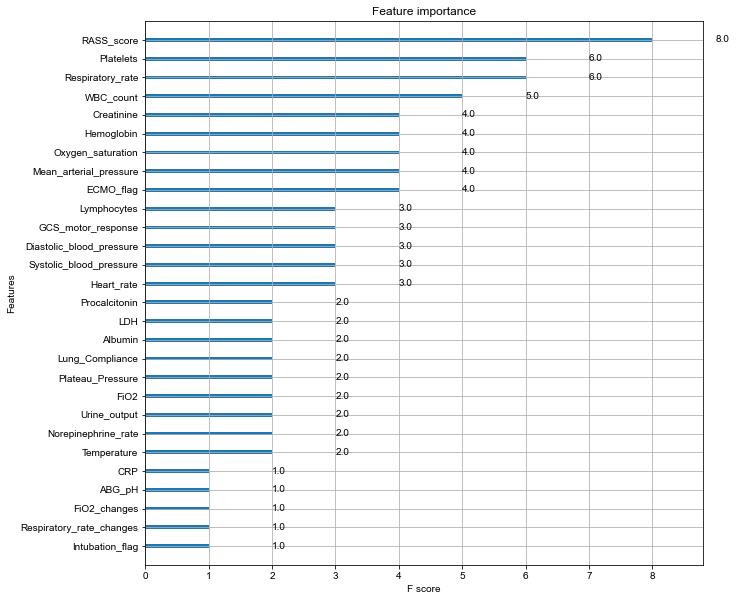

time: 478 ms (started: 2022-12-09 15:28:59 -06:00)


In [84]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)

plt.savefig(f"xgboost_last_{flag_name}_importance.pdf")


  0%|          | 0/1000 [00:00<?, ?it/s]

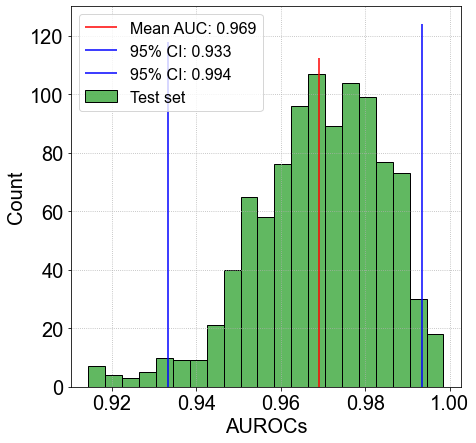

time: 38.9 s (started: 2022-12-09 15:17:28 -06:00)


In [66]:
n_boot = 1000
auc_train = []
auc_test = []


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_last_{flag_name}_bootstrap.pdf")


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


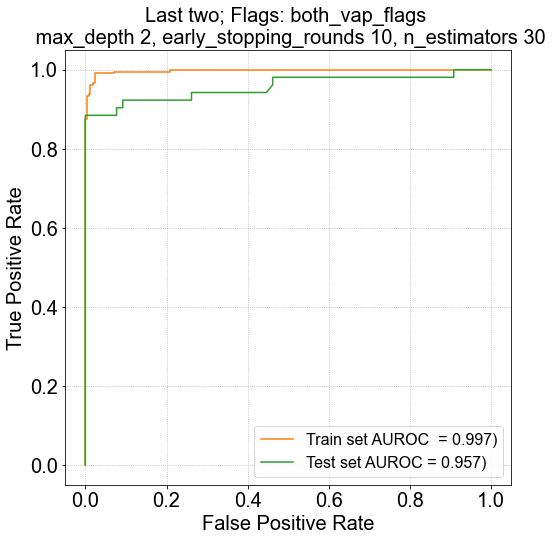

time: 284 ms (started: 2022-12-09 15:29:03 -06:00)


In [85]:
#decrease max_depth and early_stopping_rounds

max_depth = 2
early_stopping_rounds=10
n_estimators = 30

flags = both_vap_flags
flag_name = 'both_vap_flags'

#both flags
Y=worsttwo['Binary_outcome']
X = worsttwo[flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,)
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train,  early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title(f'Last two; Flags: {flag_name} \n max_depth {max_depth}, early_stopping_rounds {early_stopping_rounds}, n_estimators {n_estimators}', fontsize=20)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

fig.savefig(f"xgboost_last_{flag_name}.pdf")

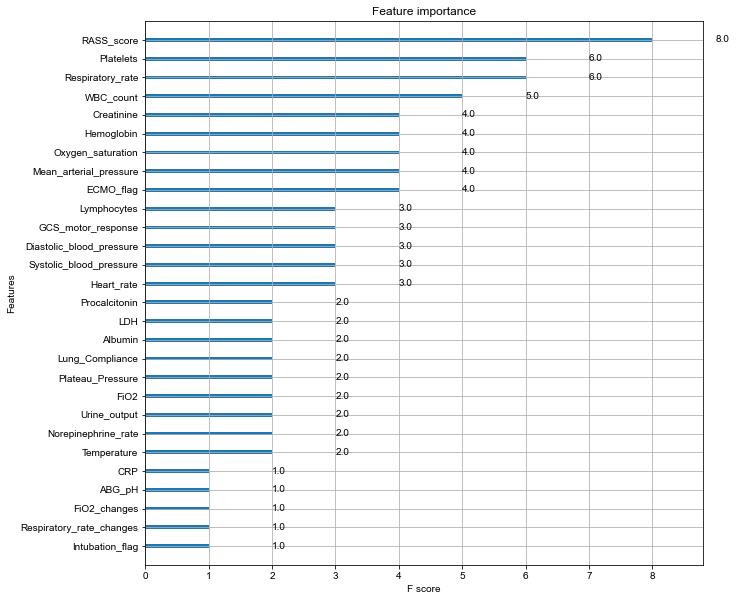

time: 387 ms (started: 2022-12-09 15:29:07 -06:00)


In [86]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)

plt.savefig(f"xgboost_last_{flag_name}_importance.pdf")


  0%|          | 0/1000 [00:00<?, ?it/s]

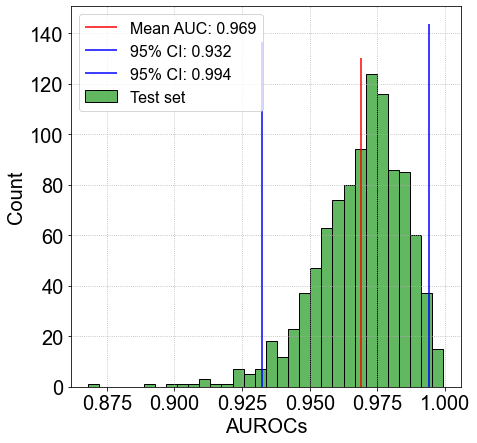

time: 40.6 s (started: 2022-12-09 15:18:08 -06:00)


In [69]:
n_boot = 1000
auc_train = []
auc_test = []


from tqdm.notebook import tqdm   # For keeping track of the loop

for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(max_depth=max_depth, use_label_encoder=False)
    eval_set = [(X_test, Y_test)]
    model_boot.fit(X_train, Y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=False)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(7,7))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


ax1.figure.savefig(f"xgboost_last_{flag_name}_bootstrap.pdf")
